In [1]:
import os
os.environ["DDE_BACKEND"] = "pytorch"

import deepxde as dde
from deepxde.backend import pytorch as torch

import matplotlib.pyplot as plt
plt.rcParams.update({"mathtext.default": "regular"})

import numpy as np

from itertools import combinations_with_replacement

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Рассмотрим 10 аналитически заданных функций $u(x,y; a,b) = \sin{a x}\cos{b y}$, где $a, b \in 1,2,7,14$ и $a \le b$. 
Тогда
$$-\Delta u(x,y) = (a^2 + b^2) u(x,y) = f(x,y) \Rightarrow f(x,y)=(a^2+b^2)\sin{ax}\cos{by},$$
$$u(0,y)=u(\pi, y)=0,\quad u(x, 0)=\sin{ax},\quad u(x,\pi)=(-1)^{b}\sin{ax}.$$

In [2]:
examples_cfg = list(combinations_with_replacement((1, 2, 7, 14), 2))

assert len(examples_cfg) == 10

Реализуем функцию, которая решает задачу Дирихле на произвольном множестве $\Omega=geom$ с заданными $f(x,y)$ и $g(x,y)$:
$$
\begin{cases}
    -\Delta u = f,\quad (x,y) \in \Omega,\\
    u = g,\quad (x, y) \in \partial \Omega
\end{cases}
$$

In [3]:
net = dde.nn.FNN([2, 75, 75, 75, 75, 1], "tanh", "Glorot uniform")

def solve_poisson(geom, f, g, n_iterations=1_000, solution=None, ckpt_path="model.ckpt", movie_path="movie"):
    def pde(x, y):
        du_xx = dde.grad.hessian(y, x, i=0, j=0)
        du_yy = dde.grad.hessian(y, x, i=1, j=1)
        return -du_xx - du_yy - f(x)

    def boundary(_, on_boundary):
        return on_boundary

    bc = dde.icbc.DirichletBC(geom, g, boundary)
    data = dde.data.PDE(geom, pde, bc, solution=solution, num_domain=1_000, num_boundary=500, num_test=1_000)

    model = dde.Model(data, net)
    model.compile("adam", lr=3e-4, metrics=["l2 relative error"])

    checkpointer = dde.callbacks.ModelCheckpoint(
        ckpt_path, verbose=1, save_better_only=True
    )

    losshistory, train_state = model.train(iterations=n_iterations, callbacks=[checkpointer])

    xy = geom.random_points(n=1_000)
    u_true, u_pred = solution(xy), model.predict(xy)
    residual = model.predict(xy, operator=pde)
    print(
        f"Solution L2 absolute error: {np.linalg.norm(u_true - u_pred, ord=2)}",
        f"Solution L2 relative error: {np.linalg.norm(u_true - u_pred, ord=2) / np.linalg.norm(u_true, ord=2)}",
        f"Solution C absolute error: {np.max(np.abs(u_true - u_pred))}",
        f"Solution C relative error: {np.max(np.abs(u_true - u_pred)) / np.max(np.abs(u_true))}",
        f"Residual L2 error: {np.linalg.norm(residual, ord='fro')}",
        f"Residual C error: {np.max(np.abs(residual))}",
        sep="\n"
    )
    return model, losshistory

In [ ]:
geom = dde.geometry.Rectangle([0., 0.], [np.pi, np.pi])
n_iterations = 30_000

In [ ]:
def get_f(a, b):
    def f(x):
        return (a**2 + b**2) * torch.sin(a * x[:, 0:1]) * torch.cos(b * x[:, 1:2])
    return f
def get_g(a, b)
    def g(x):
        boundary = np.zeros_like(x[:, 0])
        on_bottom = np.isclose(x[:, 1], 0.)
        on_top = np.isclose(x[:, 1], np.pi)
        boundary[on_bottom] = np.sin(a * x[:, 0])[on_bottom]
        boundary[on_top] = (-1)**b * np.sin(a * x[:, 0])[on_top]
        return boundary.reshape(-1, 1)
    return g

def get_solution(a, b):
    def solution(x):
        return np.sin(a * x[:, 0:1]) * np.cos(b * x[:, 1:2])
    return solution

In [4]:
results = {}
for a, b in examples_cfg:
    print("\n\n============================================")
    print(f"Training model for u(x,y)=sin({a}x)*cos({b}y)")

    f = get_f(a, b)
    g = get_g(a, b)
    solution = get_solution(a, b)
    solution_repr = r"$u(x,y)=\sin{" + str(a) + r"x}\cdot\cos{" + str(b) + "y}$"
    model, losshistory = solve_poisson(geom, f, g, n_iterations=n_iterations, solution=solution)

    results[(a, b)] = {
        "f": f,
        "g": g,
        "solution": solution,
        "solution_repr": solution_repr,
        "model": model,
        "losshistory": losshistory
    }



Training model for u(x,y)=sin(1x)*cos(1y)
Compiling model...
'compile' took 0.909303 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [9.65e-01, 2.60e-01]    [9.69e-01, 2.60e-01]    [1.06e+00]    


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: train loss improved from inf to 1.22e+00, saving model to model.ckpt-1.pt ...

1000      [2.16e-03, 7.93e-04]    [1.90e-03, 7.93e-04]    [3.97e-02]    
Epoch 1000: train loss improved from 1.22e+00 to 2.95e-03, saving model to model.ckpt-1000.pt ...

2000      [2.63e-04, 3.83e-04]    [2.08e-04, 3.83e-04]    [2.65e-02]    
Epoch 2000: train loss improved from 2.95e-03 to 6.46e-04, saving model to model.ckpt-2000.pt ...

3000      [1.05e-04, 2.22e-04]    [8.58e-05, 2.22e-04]    [1.98e-02]    
Epoch 3000: train loss improved from 6.46e-04 to 3.27e-04, saving model to model.ckpt-3000.pt ...

4000      [8.99e-05, 1.41e-04]    [7.24e-05, 1.41e-04]    [1.58e-02]    
Epoch 4000: train loss improved from 3.27e-04 to 2.31e-04, saving model to model.ckpt-4000.pt ...

5000      [7.29e-05, 9.98e-05]    [6.18e-05, 9.98e-05]    [1.32e-02]    
Epoch 5000: train loss improved from 2.31e-04 to 1.73e-04, saving model to model.ckpt-5000.pt ...

6000      [9.78e-05, 3.75e-04]    [8.38e-05, 3.75e-0

На больших частотах функция потерь минимизируется дольше, т.к. её вторая компонента сошлась быстрее первой. Очевидно, что решение в таком случае нужно искать при большем числе итераций.

In [40]:
cmap="gist_rainbow_r"
beautiful_labels = [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]

arr_to_img = lambda arr, n: arr.reshape(n, n)

def plot_model(model_cfg, N):
    xy = geom.uniform_points(N**2)
    solution, solution_repr, model = (model_cfg[attr] for attr in ("solution", "solution_repr", "model"))
    u_true, u_pred = solution(xy), model.predict(xy)

    plots_config = [
        (0, arr_to_img(u_true, N), model_cfg["solution_repr"], beautiful_labels, beautiful_labels),
        (1, arr_to_img(u_pred, N), "model", beautiful_labels, beautiful_labels),
        (2, arr_to_img(np.abs(u_pred - u_true), N), "$C norm$", beautiful_labels, beautiful_labels),
    ]
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 8), constrained_layout=True)
    
    for plot_num, cfg in enumerate(plots_config):
        i, data, title, xlabels, ylabels = cfg
        img = ax[i].imshow(data[:, ::-1], cmap=cmap)
        plots_config[plot_num] = cfg + (img, )
        ax[i].set_title(title)
        ax[i].set_xlabel("x")
        ax[i].set_ylabel("y")
        if len(xlabels) > 0:
            ax[i].set_xticks(np.linspace(0, N, len(xlabels)))
            ax[i].set_xticklabels(xlabels)
        else:
            ax[i].set_xticks([])
        if len(ylabels) > 0:
            ax[i].set_yticks(np.linspace(0, N, len(ylabels))[::-1])
            ax[i].set_yticklabels(ylabels)
        else:
            ax[i].set_yticks([])
    
    
    cbar_u = plt.colorbar(plots_config[1][-1], ax=(ax[0], ax[1]), shrink=0.4)
    cbar_d = plt.colorbar(plots_config[2][-1], ax=ax[2], shrink=0.3)
    
    for cbar in (cbar_u, cbar_d):
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
    
    plt.show()

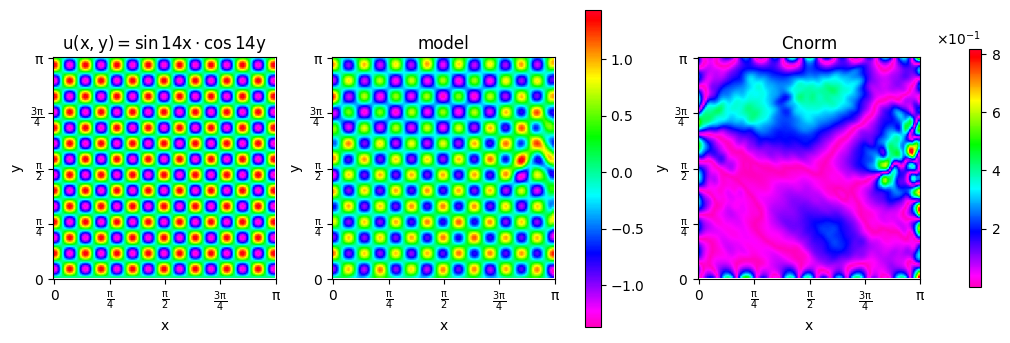

In [41]:
plot_model(results[(14, 14)], 100)